In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from skimage.feature import graycoprops, graycomatrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from skimage.color import label2rgb
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.cluster import KMeans
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
from torchvision import models
import torchvision.transforms as transforms

In [2]:
def load_images(dir_name, clip_limit=2.0, tile_grid_size=(8, 8), kernel_size=(5, 5)):
    img_list = []
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    for item in os.listdir(dir_name):
        img_path = os.path.join(dir_name, item)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        
        # Apply Gaussian blur
        img = cv2.GaussianBlur(img, kernel_size, 1)
        
        # Apply CLAHE
        img = clahe.apply(img)
        
        # Normalize image
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        
        img_list.append(img)
    
    return img_list
 


In [3]:
image_list_1 = load_images("./data_xray/Impacted fracture")
image_list_2 = load_images("./data_xray/Intra-articular fracture")
image_list_3 = load_images("./data_xray/Longitudinal fracture")
image_list_4 = load_images("./data_xray/Oblique fracture")

# LBP (Local Binary Pattern)

In [5]:
def apply_lbp_to_images(image_list, n_points=8, radius=1, method='uniform'):
    """
    Apply LBP to a list of preprocessed images
    
    Parameters:
    image_list : list of preprocessed grayscale images
    n_points : number of points to consider in the circle around each pixel
    radius : radius of the circle around each pixel
    method : the LBP method to use ('uniform', 'default', 'ror', or 'var')
    """
    lbp_images = []
    for img in image_list:
        lbp = local_binary_pattern(img, n_points, radius, method)
        lbp_images.append(lbp)
    return lbp_images

In [6]:
def visualize_original_and_lbp(original_list, lbp_list, category_name, num_samples=3):
    """
    Display original and LBP images side by side
    """
    samples = min(num_samples, len(original_list))
    fig, axes = plt.subplots(samples, 2, figsize=(10, 4*samples))
    fig.suptitle(f'{category_name} - Original vs LBP', fontsize=14)
    
    for i in range(samples):
        # Original image
        axes[i, 0].imshow(original_list[i], cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')
        
        # LBP image
        axes[i, 1].imshow(lbp_list[i], cmap='gray')
        axes[i, 1].set_title(f'LBP Image {i+1}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [7]:
lbp_images_1 = apply_lbp_to_images(image_list_1)
lbp_images_2 = apply_lbp_to_images(image_list_2)
lbp_images_3 = apply_lbp_to_images(image_list_3)
lbp_images_4 = apply_lbp_to_images(image_list_4)

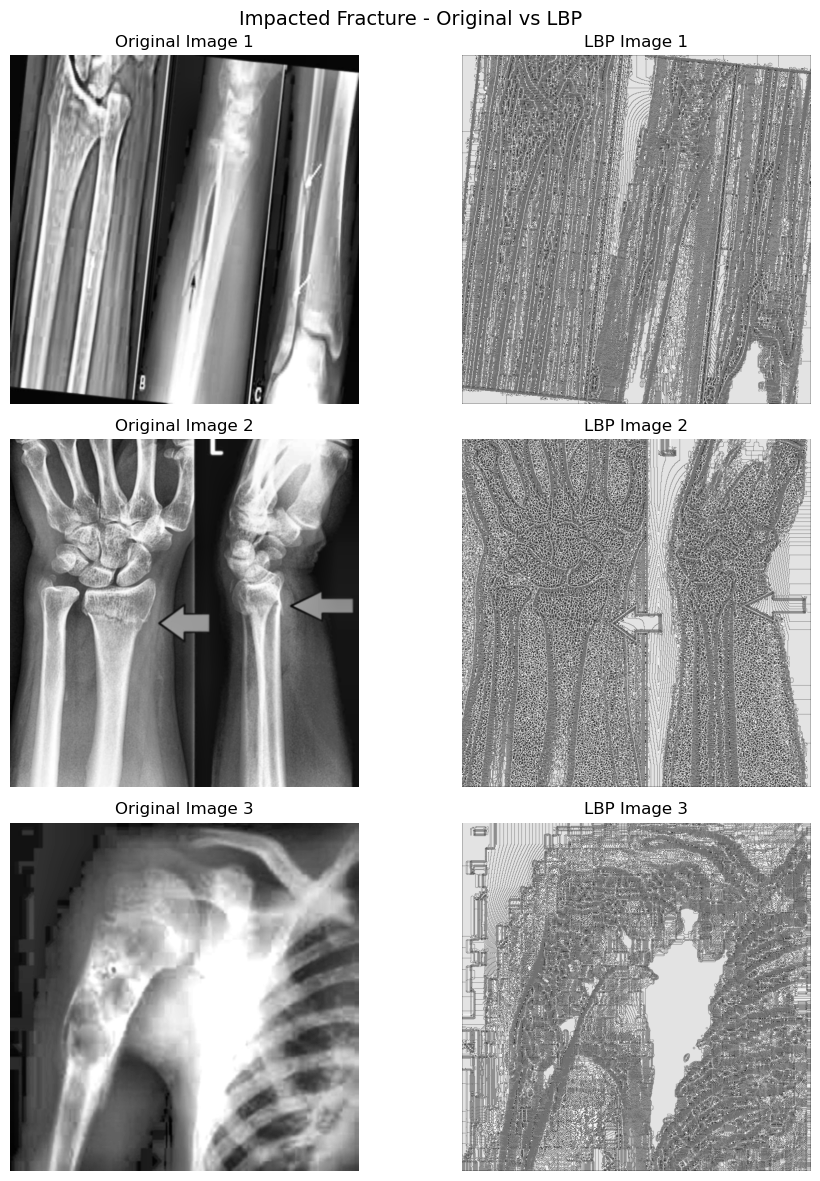

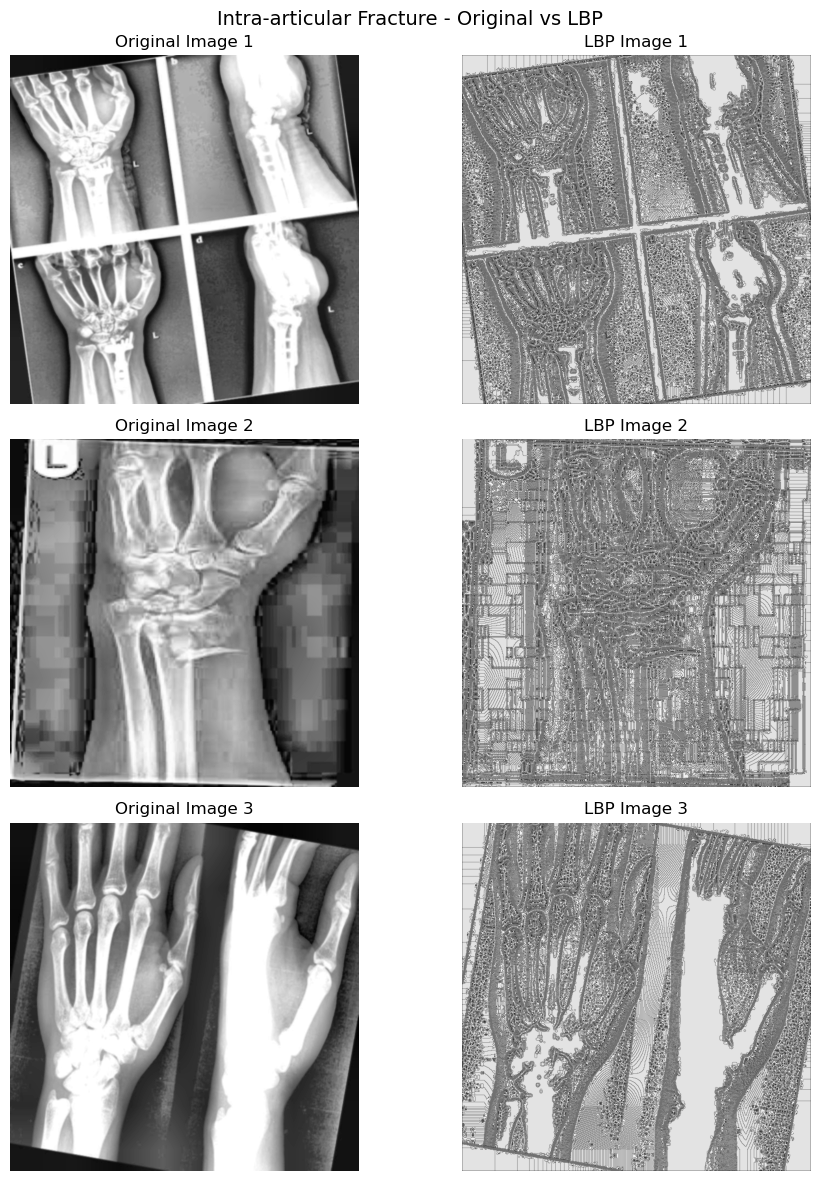

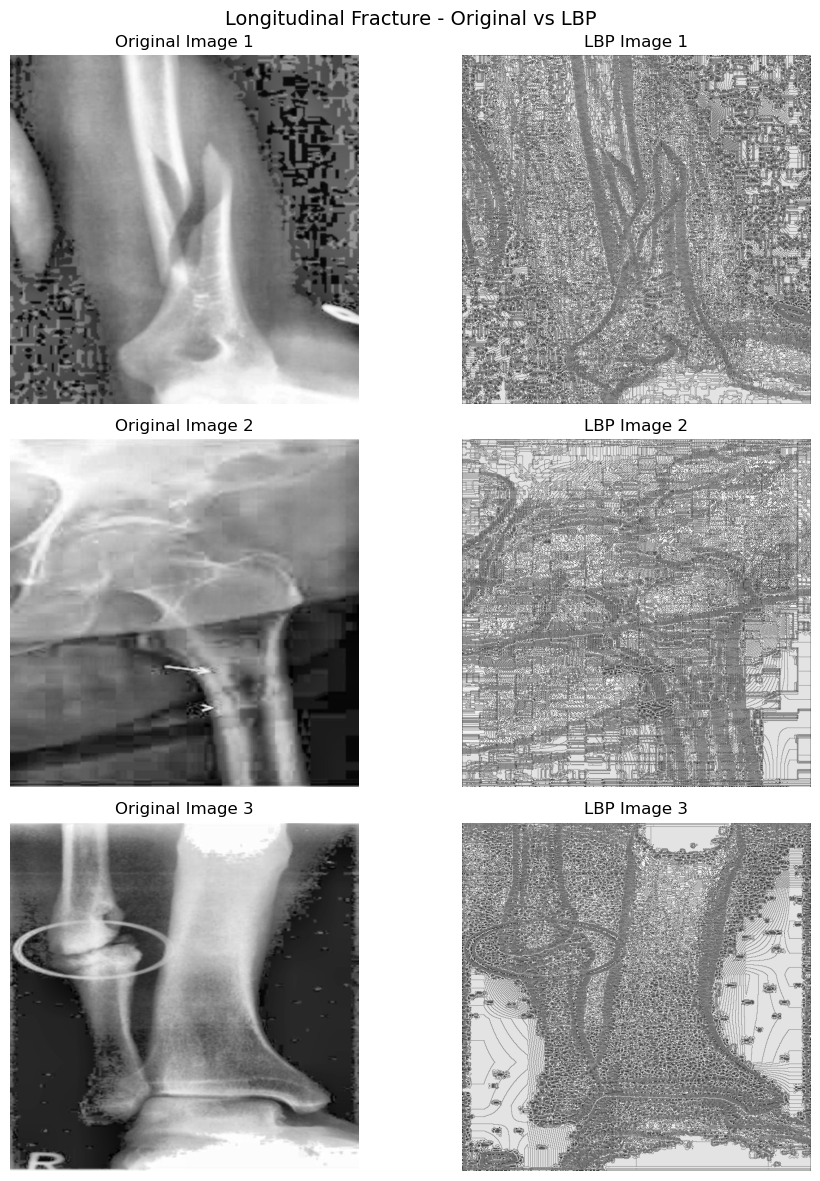

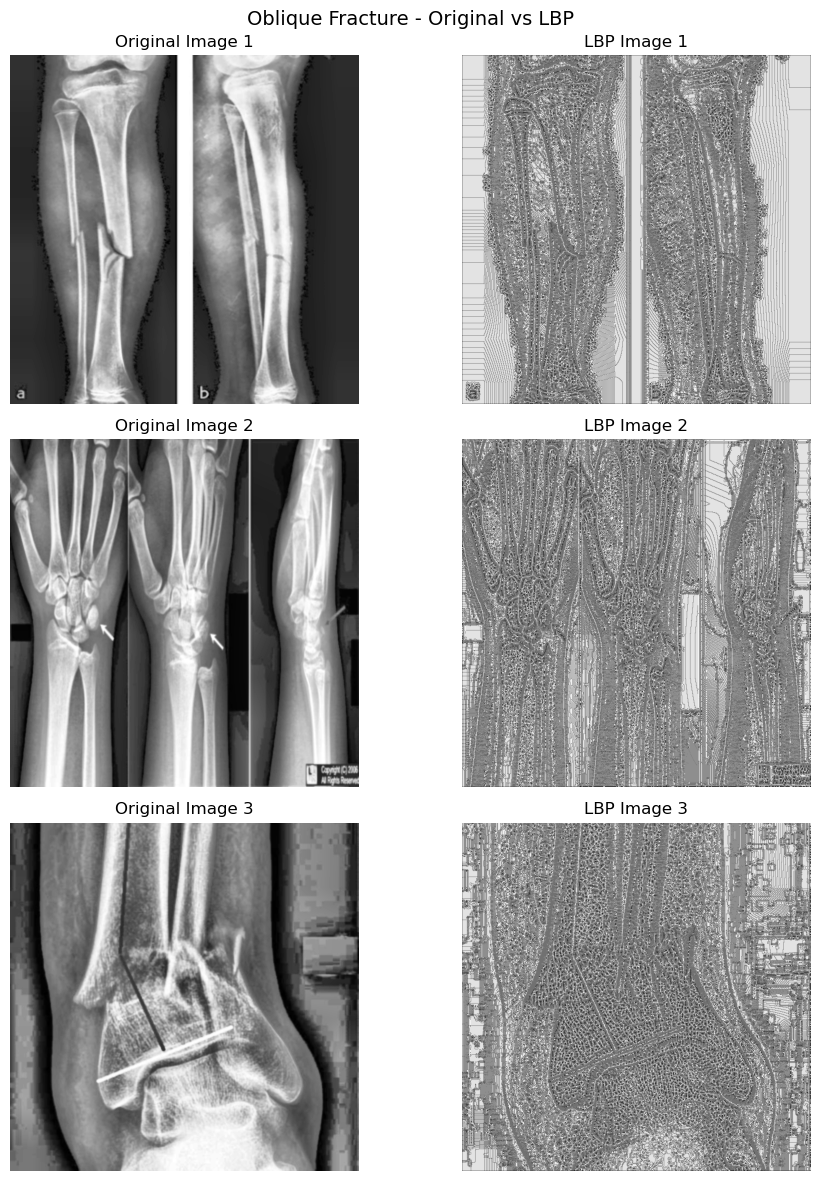

In [8]:
visualize_original_and_lbp(image_list_1, lbp_images_1, "Impacted Fracture")
visualize_original_and_lbp(image_list_2, lbp_images_2, "Intra-articular Fracture")
visualize_original_and_lbp(image_list_3, lbp_images_3, "Longitudinal Fracture")
visualize_original_and_lbp(image_list_4, lbp_images_4, "Oblique Fracture")

# PCA

In [10]:
def extract_lbp_features(lbp_images):
    """
    Extract histogram features from LBP images
    """
    features = []
    for lbp in lbp_images:
        # Calculate histogram of LBP values
        hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256), density=True)
        features.append(hist)
    return np.array(features)


In [11]:
def apply_pca_reduction(features, n_components=None, variance_threshold=0.95):
    """
    Apply PCA reduction to features
    
    Parameters:
    features : array of feature vectors
    n_components : specific number of components (if None, use variance_threshold)
    variance_threshold : minimum explained variance to retain
    """
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Initialize PCA
    if n_components is None:
        pca = PCA()
        pca.fit(scaled_features)
        
        # Find number of components needed to explain variance_threshold of variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        
        # Create new PCA with determined number of components
        pca = PCA(n_components=n_components)
    else:
        pca = PCA(n_components=n_components)
    
    # Transform features
    reduced_features = pca.fit_transform(scaled_features)
    
    return reduced_features, pca

In [12]:
def plot_explained_variance(pca):
    """
    Plot explained variance ratio and cumulative explained variance
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scree plot
    variance_ratio = pca.explained_variance_ratio_
    ax1.plot(range(1, len(variance_ratio) + 1), variance_ratio, 'bo-')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot')
    
    # Cumulative variance plot
    cumulative_variance = np.cumsum(variance_ratio)
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
    ax2.axhline(y=0.95, color='k', linestyle='--', label='95% Threshold')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.set_title('Cumulative Explained Variance')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [13]:
features_1 = extract_lbp_features(lbp_images_1)
features_2 = extract_lbp_features(lbp_images_2)
features_3 = extract_lbp_features(lbp_images_3)
features_4 = extract_lbp_features(lbp_images_4)

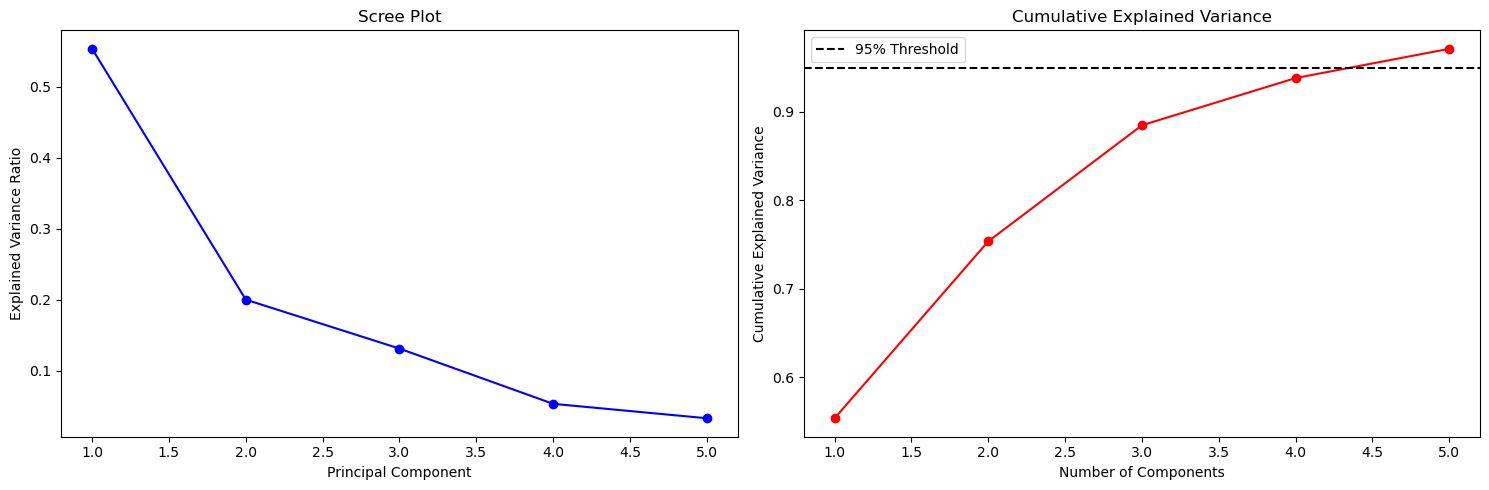

Original feature dimension: 256
Reduced feature dimension: 5
Total explained variance: 0.9713


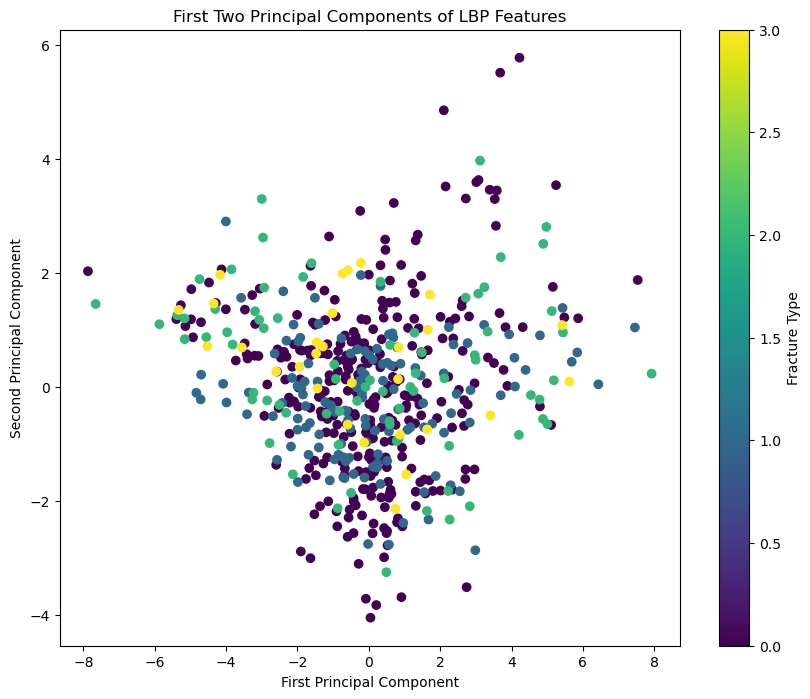

In [14]:
X = np.vstack([features_1, features_2, features_3, features_4])
y = np.concatenate([
    np.zeros(len(features_1)),  # Class 0 for Impacted
    np.ones(len(features_2)),   # Class 1 for Intra-articular
    2 * np.ones(len(features_3)), # Class 2 for Longitudinal
    3 * np.ones(len(features_4))  # Class 3 for Oblique
])

# Apply PCA
reduced_features, pca = apply_pca_reduction(X, variance_threshold=0.95)

# Plot explained variance
plot_explained_variance(pca)

# Print information about the reduction
print(f"Original feature dimension: {X.shape[1]}")
print(f"Reduced feature dimension: {reduced_features.shape[1]}")
print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# Visualize first two principal components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components of LBP Features')
plt.colorbar(scatter, label='Fracture Type')
plt.show()

# Training and Classification

In [16]:
def train_and_evaluate_svm(X, y, test_size=0.2, random_state=42):
    """
    Train and evaluate SVM classifier
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Initialize and train SVM
    print("Training SVM classifier...")
    svm = SVC(kernel='rbf', random_state=random_state)
    svm.fit(X_train, y_train)
    
    # Make predictions
    y_pred = svm.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return svm, accuracy, y_test, y_pred, X_train, X_test, y_train

In [17]:
def plot_results(y_test, y_pred):
    """
    Plot confusion matrix
    """
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - SVM Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [18]:
svm_model, accuracy, y_test, y_pred, X_train, X_test, y_train = train_and_evaluate_svm(reduced_features, y)

Training SVM classifier...


In [19]:
print("\nClassification Results:")
print("-" * 50)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Impacted', 'Intra-articular', 
                                      'Longitudinal', 'Oblique']))


Classification Results:
--------------------------------------------------
Accuracy: 0.5856

Classification Report:
                 precision    recall  f1-score   support

       Impacted       0.60      1.00      0.75        64
Intra-articular       0.00      0.00      0.00        26
   Longitudinal       0.25      0.07      0.11        15
        Oblique       0.00      0.00      0.00         6

       accuracy                           0.59       111
      macro avg       0.21      0.27      0.21       111
   weighted avg       0.38      0.59      0.45       111



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
